In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import time

from xgboost import XGBRFRegressor, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.inspection      import permutation_importance

from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error

from sklearn import tree
from sklearn.tree import export_graphviz
#import graphviz
import shap
import pickle

from Plots import plot_hist
from Plots import Plot_TestPred

import multiprocessing
n_threads=multiprocessing.cpu_count()

from wurlitzer import sys_pipes

import warnings

/home/aidin/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Read data 

In [2]:
dir      = "DATA/"
file1    = 'BHBH_Delay_Time.csv'
file2    = 'BHBH_Delay_Time_Shuffled.csv'

BHBH     = pd.read_csv(dir+file1)
BHBH.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)

# shuffled dataset 
shuffled = pd.read_csv(dir+file1)
shuffled.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)
shuffled.head()

,Index,ID,name,BWorldtime,Mass_0,Radius_0,Zams_0,Phase_0,RemnantType_0,Mass_1,...,Events,EventsPlus,Mzams_0,Mzams_1,Semimajor_ini,Eccentricity_ini,Z,alpha,Delay_Time,Eccentricity_Delay
0,0,360308,0_792857804219921,5.411991,18.34303,0.000078,21.22227,7,6,21.09631,...,RB:RE:S:RB:RE:S,RB:RE:ehSt:RB:RE:erSt,41.0592,34.5745,24.874630,0.2619,0.0004,0.5,9.993410e+04,6.409107e-11
1,1,360337,0_285120263308905,4.134819,50.99943,0.000217,92.24360,7,6,51.78028,...,S:S,hhS:hrS,92.2436,53.6410,81917.701038,0.3955,0.0004,0.5,5.520443e+16,4.934820e-14
2,2,360367,0_303570516402716,4.311590,33.98611,0.000144,41.10912,7,6,30.83786,...,RB:RE:RB:RE:S:RB:RE:S,RB:RE:RB:RE:ehSt:RB:RE:erSt,74.5563,46.8471,127.422203,0.2217,0.0004,0.5,7.108337e+05,1.981434e-10
3,3,360429,0_321152334354104,5.738531,42.61480,0.000181,50.85000,7,6,33.31328,...,RB:S:RE:RB:S,RB:hhS:RE:RB:hrS,50.8500,32.3486,316.947946,0.0107,0.0004,0.5,1.214966e+07,2.425785e-12
4,4,360471,0_850952161687565,4.503749,49.74939,0.000211,65.22210,7,6,45.91471,...,RB:S:RE:RB:S,RB:hhS:RE:RB:hrS,65.2221,46.7855,1548.080290,0.0751,0.0004,0.5,5.995947e+09,1.042263e-11


In [3]:
"""
# random swap of Mass_0 and Mass_1
idx = np.random.rand(len(BHBH)) < 0.5

# passing numpy array to bypass column alignment
BHBH.loc[idx, ['Mass_0','Mass_1']] = BHBH.loc[idx, ['Mass_1','Mass_0']].to_numpy()
"""

"\n# random swap of Mass_0 and Mass_1\nidx = np.random.rand(len(BHBH)) < 0.5\n\n# passing numpy array to bypass column alignment\nBHBH.loc[idx, ['Mass_0','Mass_1']] = BHBH.loc[idx, ['Mass_1','Mass_0']].to_numpy()\n"

In [4]:
### Normalization of each column
features       = BHBH[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha']]
features_shfld = shuffled[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha']]

# min-max normalization
#features = (features-features.min())/(features.max()-features.min())

# mean normalization
features=(features-features.mean())/features.std()
features_shfld=(features_shfld-features_shfld.mean())/features_shfld.std()

#features['Delay_Time'] = np.log10(BHBH.Delay_Time)

X = features.to_numpy()
Y = np.log10(BHBH.Delay_Time).to_numpy()

X_test2 = features_shfld.to_numpy()
Y_test2 = np.log10(shuffled.Delay_Time).to_numpy()

In [5]:
"""
features = ['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha']
#features = ['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity']
#features = ['Mass_0']

# define attributes based on knowledge
# should we use the others?
X = BHBH[features].to_numpy()
Y = BHBH.Delay_Time.to_numpy()

X_test2 = shuffled[features].to_numpy()
Y_test2 = shuffled.Delay_Time.to_numpy()"""

"\nfeatures = ['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha']\n#features = ['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity']\n#features = ['Mass_0']\n\n# define attributes based on knowledge\n# should we use the others?\nX = BHBH[features].to_numpy()\nY = BHBH.Delay_Time.to_numpy()\n\nX_test2 = shuffled[features].to_numpy()\nY_test2 = shuffled.Delay_Time.to_numpy()"

### Split training and test set

In [6]:
# split train and test set (80% training, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=0)
X_train

array([[-1.20987771, -0.99501129, -0.01219004, -0.7829777 ,  0.15832631,
         0.30547481],
       [ 0.68782199,  0.14486855,  0.01122613,  0.0264237 , -0.73951495,
         0.30547481],
       [ 0.23418679,  0.43262346, -0.00977097,  1.11557189, -0.15127412,
         0.30547481],
       ...,
       [ 0.62499048,  0.14645413, -0.01203905,  0.36225867, -0.75499497,
         0.30547481],
       [-0.80835729, -1.23215121, -0.01216042,  0.2961545 , -0.15127412,
        -1.09555723],
       [-1.1529415 , -0.92520152, -0.01219597, -0.52201575, -0.46087456,
         1.42630043]])

In [7]:
del BHBH, X, Y, shuffled

## Scikit-learn Random Forest

In [8]:
# model definition for the regressor
# using mostly the default parameters
#regressor=RandomForestRegressor(n_estimators=10, criterion='squared_error',
#                                max_depth=10, min_samples_split=2,
#                                min_samples_leaf=1, min_weight_fraction_leaf=0.0,
#                                max_features=1.0, max_leaf_nodes=None,
#                                min_impurity_decrease=.0, bootstrap=True,
#                                oob_score=False, n_jobs=-1,
#                                random_state=0,
#                                verbose=1)

#regressor=RandomForestRegressor(n_estimators = 50, random_state = 42,
#                                n_jobs=-1, verbose=1)
regressor=RandomForestRegressor(n_jobs=-1, verbose=1)

regressor.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 1,
 'warm_start': False}

In [9]:
# traininig of the model
regressor.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.5min finished


RandomForestRegressor(n_jobs=-1, verbose=1)

In [10]:
"""pkl_filename = 'MODELS/sklearn_model.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(regressor, file)"""

"pkl_filename = 'MODELS/sklearn_model.pkl'\nwith open(pkl_filename, 'wb') as file:\n    pickle.dump(regressor, file)"

In [11]:
# make predictions to compare with Y_test
Y_pred  = regressor.predict(X_test)
Y_pred2 = regressor.predict(X_test2)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   10.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   25.9s finished


In [12]:
print('Score of the regressor for the training set:\n', regressor.score(X_train, Y_train))
print('\nScore of the regressor for the test set:\n',   regressor.score(X_test,  Y_test ))
print('\nScore of the regressor for the test set:\n',   regressor.score(X_test2, Y_test2 ))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   31.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Score of the regressor for the training set:
 0.9999935297403072


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.



Score of the regressor for the test set:
 0.9999584186856333


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    9.4s



Score of the regressor for the test set:
 0.9999864983940968


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   24.3s finished


In [13]:
#print('R^2 Score of the regressor for the test set:\n', r2_score(Y_test,  Y_pred ))
print('Mean squared log error of the regressor for the test set:\n', mean_squared_log_error(10**Y_test, 10**Y_pred ))
print('Mean squared error of the regressor for the test set:\n', mean_squared_error(Y_test,  Y_pred ))

Mean squared log error of the regressor for the test set:
 0.003925865306058746
Mean squared error of the regressor for the test set:
 0.0007678489767769994


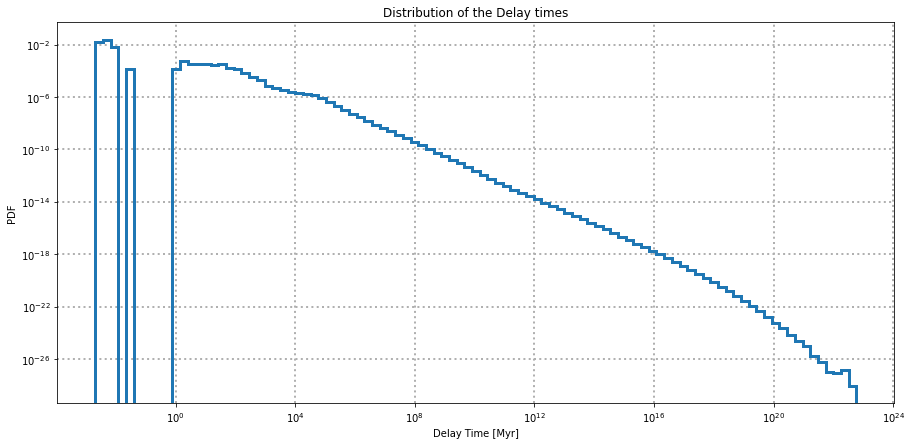

In [14]:
plot_hist(10**Y_pred, 100)

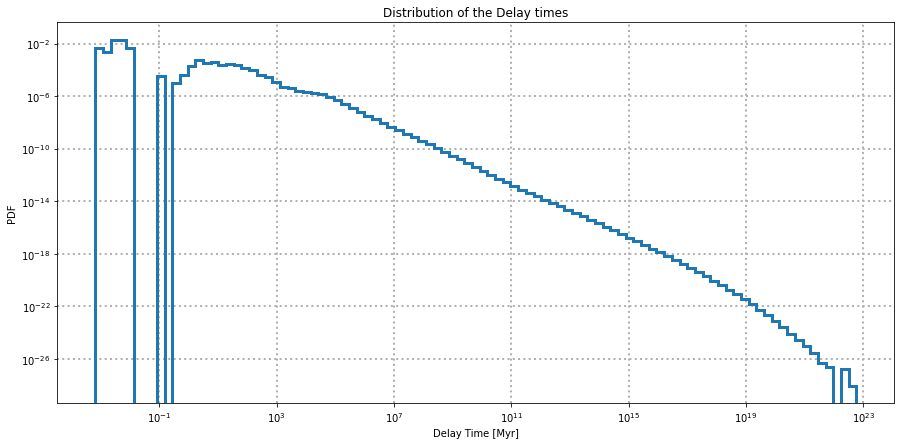

In [15]:
plot_hist(10**Y_test, 100)

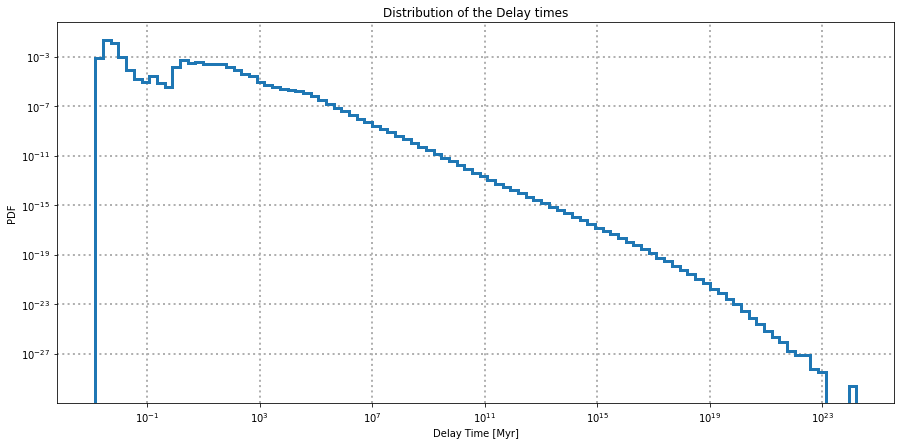

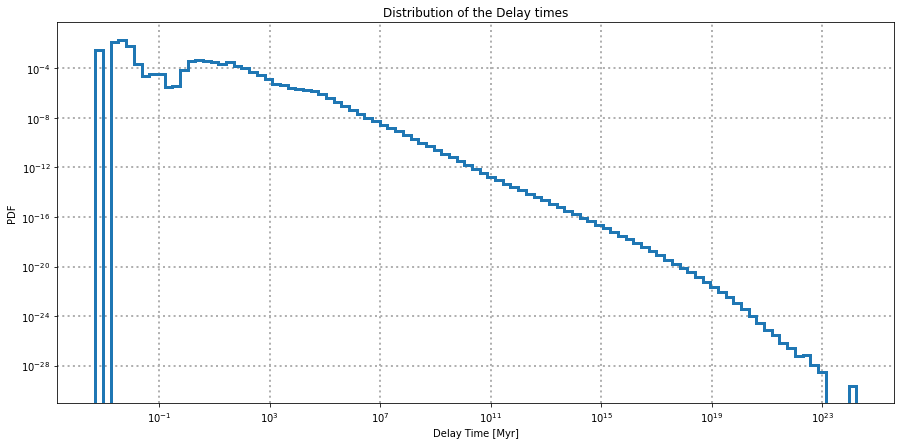

In [21]:
plot_hist(10**Y_pred2, 100)
plot_hist(10**Y_test2, 100)

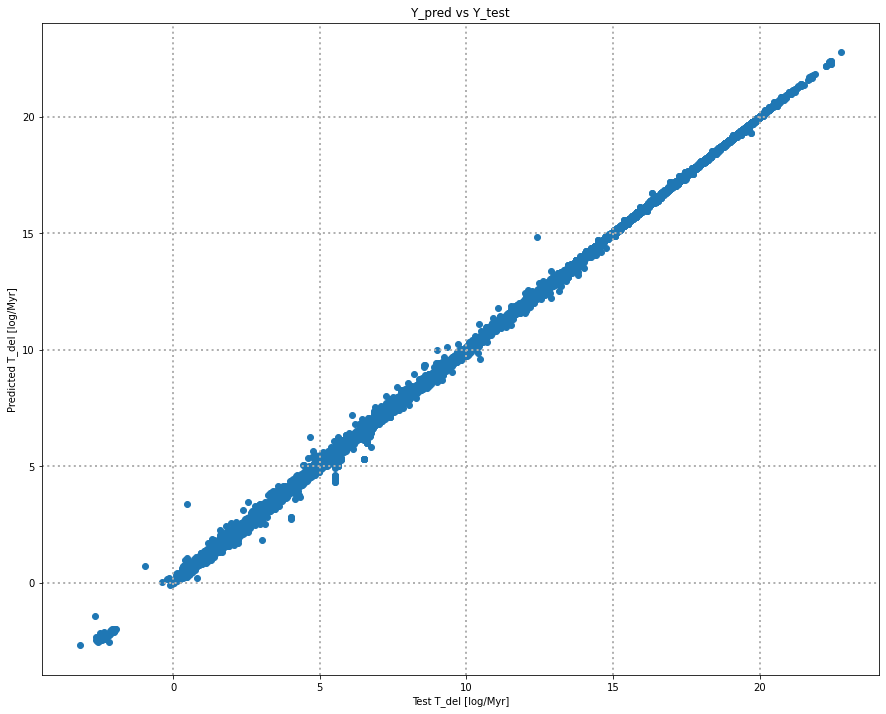

In [22]:
Plot_TestPred(Y_pred=Y_pred, Y_test=Y_test, log=False)

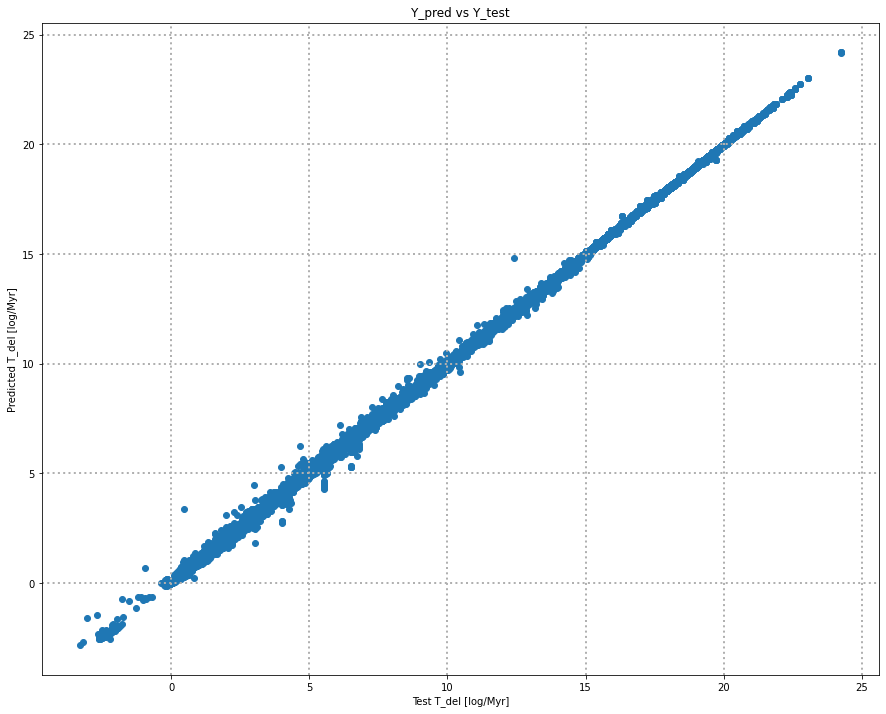

In [23]:
Plot_TestPred(Y_pred=Y_pred2, Y_test=Y_test2, log=False)

[0.02756779 0.00568678 0.91255815 0.01602509 0.03563258 0.0025296 ]


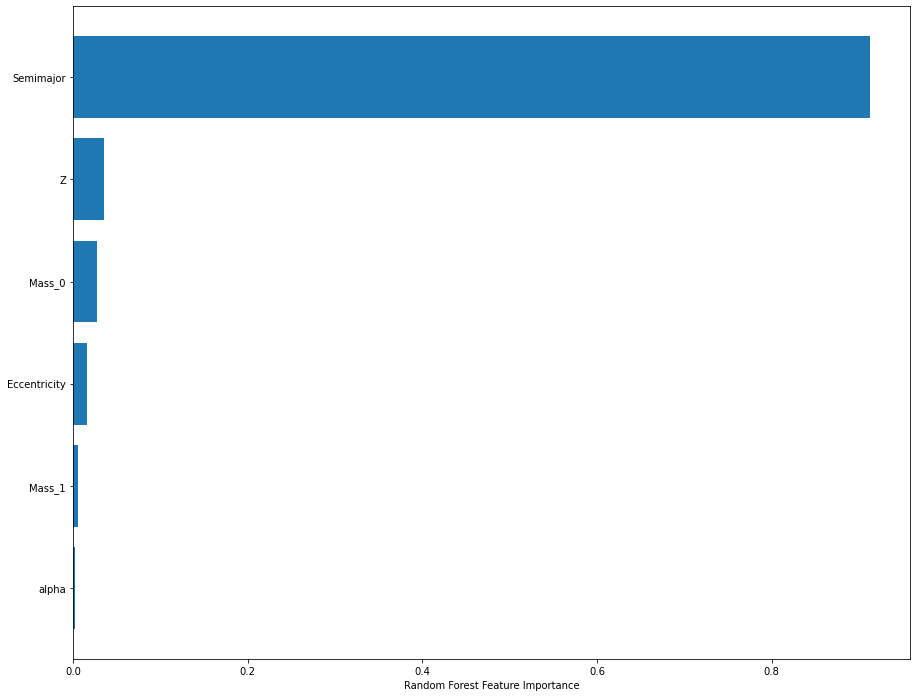

In [24]:
print(regressor.feature_importances_)

feature_names = np.array(['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha'])

sorted_idx = regressor.feature_importances_.argsort()

fig, ax = plt.subplots(figsize=(15,12))

ax.barh(feature_names[sorted_idx], regressor.feature_importances_[sorted_idx])
ax.set_xlabel("Random Forest Feature Importance")

plt.show()

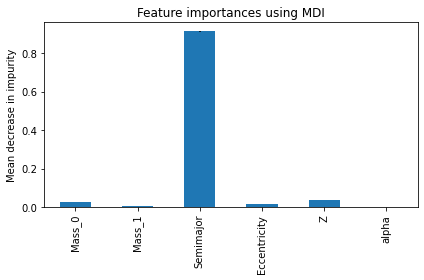

In [25]:
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [25]:
forest_importances

Mass_0          0.027460
Mass_1          0.005713
Semimajor       0.912661
Eccentricity    0.016020
Z               0.035601
alpha           0.002545
dtype: float64

In [ ]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(regressor.estimators_[0], 
                   feature_names=['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha'],
                   filled=True)

KeyboardInterrupt: 

In [ ]:
dot_data = export_graphviz(regressor.estimators_[0],
                           feature_names=['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha'],  
                           filled=True, rounded=True)  

graph = graphviz.Source(dot_data, format='png')
graph.render("tree") 

From here it is problematic: using 100 as number of trees and using 30% of the data results in using already almost all the ram (16Gb).

## Tuning of the hyperparameters
First we do a random grid search

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {#'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                               n_iter = 5, cv = 3, verbose=3, 
                               random_state=42, n_jobs = 1)

# Fit the random search model
with sys_pipes():
    rf_random.fit(X_train, Y_train)

In [ ]:
def evaluate_accuracy(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate_accuracy(best_random, X_test, Y_test)

In [ ]:
best_random

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)

## XGBoost

In [9]:
### Normalization of each column
features = BHBH[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha', 'Delay_Time']]

# min-max normalization
features = (features-features.min())/(features.max()-features.min())

# mean normalization
#features=(features-features.mean())/features.std()

In [ ]:
# define attributes based on knowledge
# should we use the others?
X = features[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha']].to_numpy()
Y = features.Delay_Time.to_numpy()

# split train and test set (80% training, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=0)
Y_train

In [10]:
# definition of the model
model = XGBRFRegressor(n_jobs=-1, verbosity=3)
# traininig of the model
model.fit(X_train, Y_train, eval_set=[(X_test, Y_test)])

print("Test  R2 Score : %.2f"%model.score(X_test,  Y_test ))
print("Train R2 Score : %.2f"%model.score(X_train, Y_train))

[11:42:42] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[11:43:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[11:43:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[11:43:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[11:43:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[11:43:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[11:43:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[11:43:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[11:43:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[11:43:53] INFO: ../src

In [12]:
# make predictions to compare with Y_test
Y_pred = model.predict(X_test)

print('Score of the regressor for the training set:\n', model.score(X_train, Y_train))
print('\nScore of the regressor for the test set:\n',   model.score(X_test,  Y_test ))
print('R^2 Score of the regressor for the test set:\n', r2_score(Y_test,  Y_pred ))
print('Mean squared log error of the regressor for the test set:\n', mean_squared_log_error(10**Y_test,  10**Y_pred ))
print('Mean squared error of the regressor for the test set:\n', mean_squared_error(Y_test,  Y_pred ))

Score of the regressor for the training set:
 0.9906092211815819

Score of the regressor for the test set:
 0.9906980864632032
R^2 Score of the regressor for the test set:
 0.9906980864632032
Mean squared log error of the regressor for the test set:
 0.8965930883634327
Mean squared error of the regressor for the test set:
 0.1717710202304637


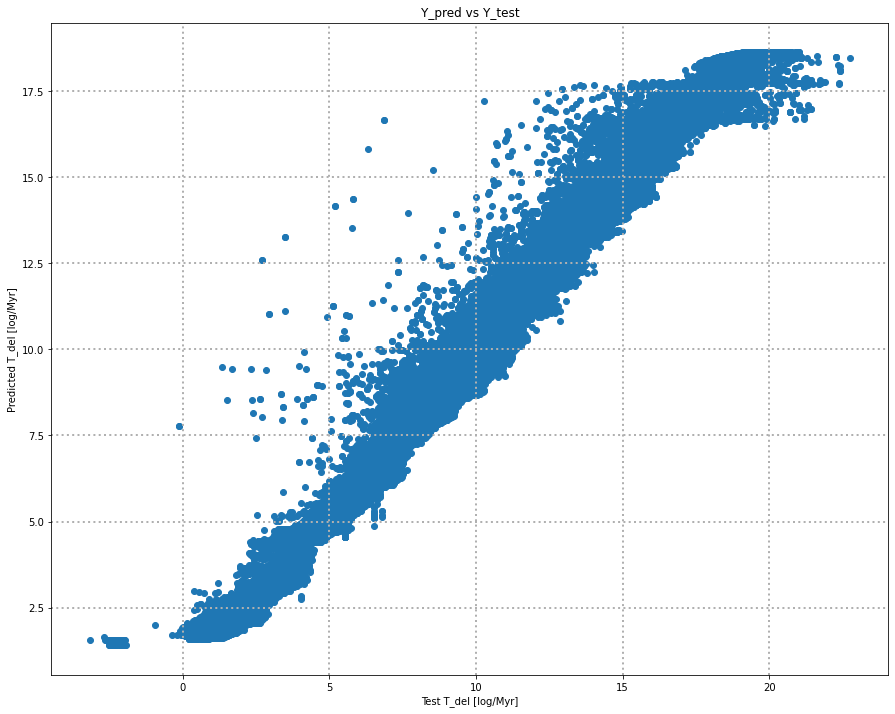

In [13]:
Plot_TestPred(Y_pred=Y_pred, Y_test=Y_test, log=False)

### GridSearch

In [ ]:
random_grid = {
    'n_estimators': [100, 200, 300, 500, 1000],
    #'learning_rate': [.01, .05, .1, .2],
    #'max_depth': [None, 3, 5, 7, 10],
    #'min_child_weight': [None, 1, 3, 5],
    #'subsample': [None, .1, .5, .7],
    #'colsample_bytree': [None, .1, .5, .7],
    #'objective': ['reg:squarederror']
}

random_grid

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = XGBRFRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                               n_iter = 2, cv = 3, verbose=10, 
                               random_state=42, n_jobs = -1)

# Fit the random search model
with sys_pipes():
    rf_random.fit(X_train, Y_train)
    
    
print("Test  R2 Score : %.2f"%rf_random.score(X_test, Y_test))
print("Train R2 Score : %.2f"%rf_random.score(X_train, Y_train))

print("Best Params : ", rf_random.best_params_)
print("Feature Importances : ")
pd.DataFrame([rf_random.best_estimator_.feature_importances_], columns=['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha'])

In [ ]:
pd.DataFrame.from_dict(rf_random.cv_results_)

### Using Tensorflow

In [11]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from IPython.display import display, HTML

In [12]:
"""### Normalization over the whole dataset

features_all = BHBH[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha', 'Delay_Time']]

min_value = np.min (np.min (features_all, axis=0))
max_value = np.max (np.max (features_all, axis=0))
avg_value = np.mean(np.mean(features_all, axis=0))
std_value = np.std (np.std (features_all, axis=0))

method = 'norm'  #norm, std, log

def normalizer(x):
    if method == 'norm':
        return (x-min_value)/(max_value-min_value)
    elif method =='std':
        return (x- avg_value)/std_value
    elif method =='log':
        return np.log10(x)

features_all = features_all.apply(normalizer)"""

"### Normalization over the whole dataset\n\nfeatures_all = BHBH[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha', 'Delay_Time']]\n\nmin_value = np.min (np.min (features_all, axis=0))\nmax_value = np.max (np.max (features_all, axis=0))\navg_value = np.mean(np.mean(features_all, axis=0))\nstd_value = np.std (np.std (features_all, axis=0))\n\nmethod = 'norm'  #norm, std, log\n\ndef normalizer(x):\n    if method == 'norm':\n        return (x-min_value)/(max_value-min_value)\n    elif method =='std':\n        return (x- avg_value)/std_value\n    elif method =='log':\n        return np.log10(x)\n\nfeatures_all = features_all.apply(normalizer)"

### Normalization of the data

In [13]:
### Normalization of each column
features = BHBH[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha']]

# min-max normalization
#features = (features-features.min())/(features.max()-features.min())

# mean normalization
features=(features-features.mean())/features.std()

features['Delay_Time'] = np.log10(BHBH.Delay_Time)

### Split in training and validation

In [14]:
# Split the dataset into a training and a testing dataset.
def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

In [15]:
# Split the dataset into a training and testing dataset.
train_ds_pd, test_ds_pd = split_dataset(dataset=features, test_ratio=.9)
print("{} examples in training, {} examples for testing.".format(len(train_ds_pd), len(test_ds_pd)))

205409 examples in training, 1849631 examples for testing.


In [16]:
X_train = train_ds_pd[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha']].to_numpy()
Y_train = train_ds_pd.Delay_Time.to_numpy()

X_test  = test_ds_pd[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha']].to_numpy()
Y_test  = test_ds_pd.Delay_Time.to_numpy()

# Name of the label column.
label = "Delay_Time"

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds  = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd,  label=label, task=tfdf.keras.Task.REGRESSION)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


### Training of the model

In [17]:
# Configure the model.
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION, num_threads=n_threads)

# Configure the metrics (Eventually add other metrics).
model.compile(metrics=["mse", "mape"])

# Train the model.
with sys_pipes():
    model.fit(train_ds)

Use /tmp/tmp07qa841x as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.497258. Found 205409 examples.
Training model...


[INFO kernel.cc:1176] Loading model from path /tmp/tmp07qa841x/model/ with prefix c1f33d2bdfd245ed
[INFO abstract_model.cc:1246] Engine "RandomForestOptPred" built
[INFO kernel.cc:1022] Use fast generic engine


Model trained in 0:00:40.549726
Compiling model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [18]:
model.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (6):
	Eccentricity
	Mass_0
	Mass_1
	Semimajor
	Z
	alpha

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.      "__LABEL" 14.363688 ################
    2.        "alpha" 13.190288 ##############
    3.       "Mass_1"  6.231735 ######
    4.            "Z"  4.995672 ####
    5. "Eccentricity"  4.497082 ####
    6.       "Mass_0"  4.279708 ###
    7.    "Semimajor"  1.026179 

Variable Importance: NUM_AS_ROOT:
    1.    "Semimajor" 141.000000 ################
    2. "Eccentricity" 106.000000 ###########
    3.       "Mass_0" 45.000000 ####
    4.            "Z"  8.000000 

Variable Importance: NUM_NODES:
    1.    "Semimajor" 11

In [19]:
# inspect the features used in the model
model.make_inspector().features()

["Eccentricity" (1; #0),
 "Mass_0" (1; #1),
 "Mass_1" (1; #2),
 "Semimajor" (1; #3),
 "Z" (1; #4),
 "alpha" (1; #5)]

In [20]:
#evaluation = model.evaluate(test_ds, return_dict=True)
evaluation = model.evaluate(test_ds, return_dict=True)

print(evaluation)
print(f"MSE: {evaluation['mse']:.2f}")
print(f"RMSE: {np.sqrt(evaluation['mse']):.2f}")
#print(f"MAPE: {evaluation['mape']:.2f}")

1850/1850 [==============================] - 84s 45ms/step - loss: 0.0000e+00 - mse: 0.0107 - mape: 1.2230
{'loss': 0.0, 'mse': 0.01071587111800909, 'mape': 1.223013162612915}
MSE: 0.01
RMSE: 0.10


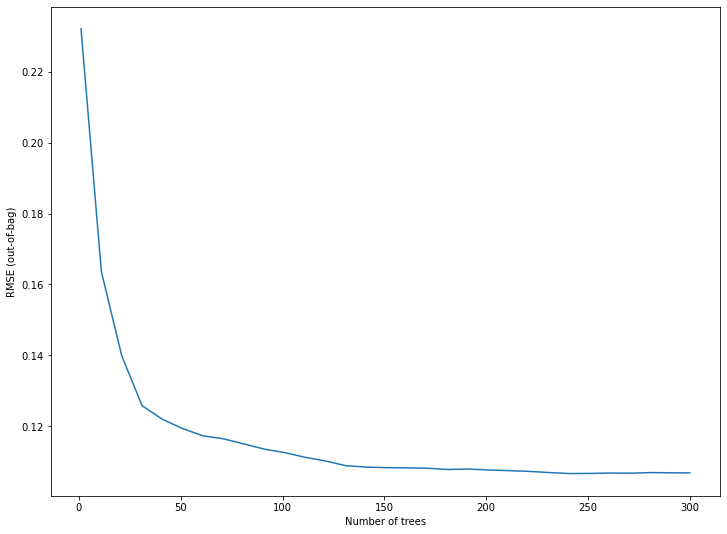

In [21]:
logs = model.make_inspector().training_logs()

fig, ax = plt.subplots(figsize=(12, 9))

ax.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
ax.set_xlabel("Number of trees")
ax.set_ylabel("RMSE (out-of-bag)")
plt.show()

In [22]:
# make predictions to compare with Y_test
Y_pred = model.predict(test_ds)

1850/1850 [==============================] - 84s 46ms/step


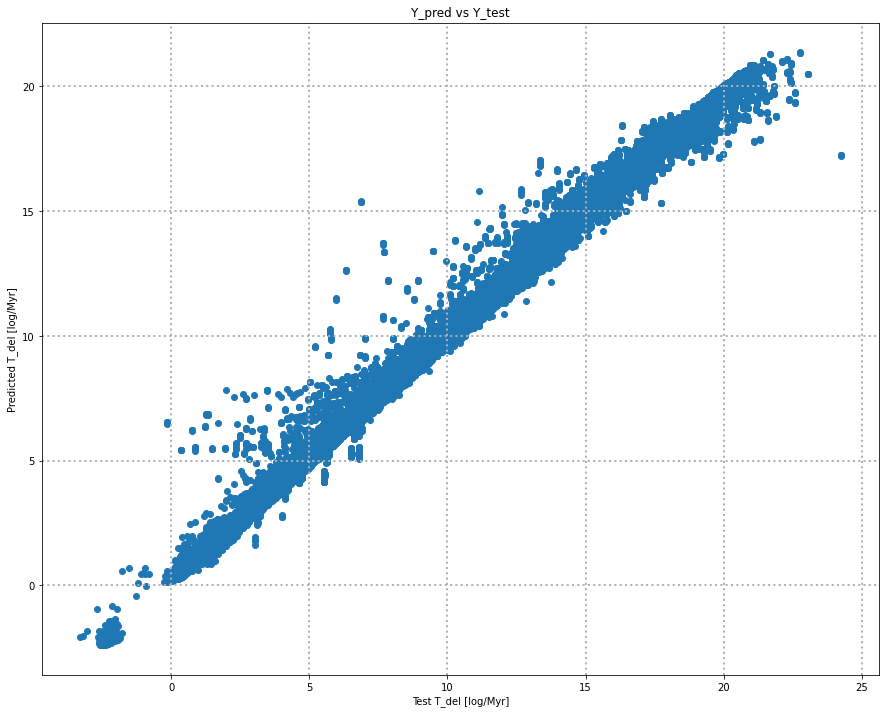

In [23]:
Plot_TestPred(Y_pred=Y_pred, Y_test=Y_test, log=False)

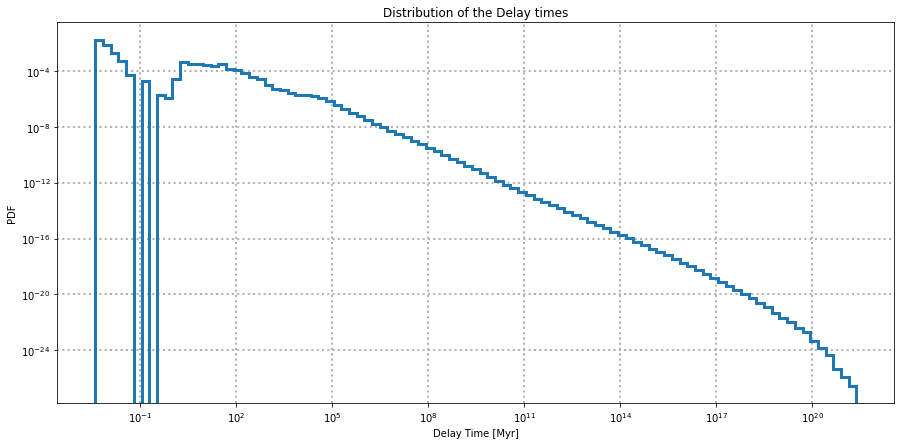

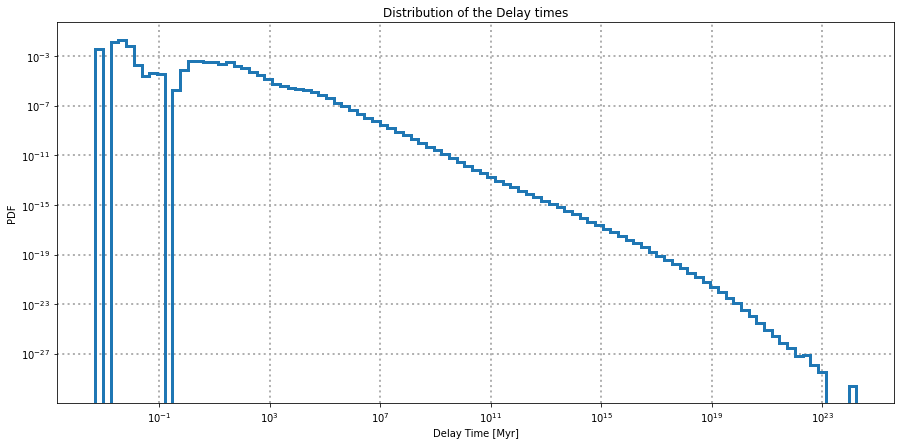

In [24]:
plot_hist(10**Y_pred[:,0], 100, False)
plot_hist(10**Y_test,      100, False)

In [25]:
print('Score of the regressor for the training set:\n', model.score(X_train, Y_train))
print('\nScore of the regressor for the test set:\n',   model.score(X_test,  Y_test ))
#print('\nScore of the regressor for the test set:\n',   model.score(X_test2, Y_test2 ))
print('Mean squared log error of the regressor for the test set:\n', mean_squared_log_error(10**Y_test, 10**Y_pred ))
print('Mean squared error of the regressor for the test set:\n', mean_squared_error(10**Y_test, 10**Y_pred ))

NameError: name 'regressor' is not defined

In [ ]:
# plot the first tree, restricted to depth of 3
tfdf.model_plotter.plot_model(model, tree_idx=0, max_depth=3)

In [9]:
# Number of trees in random forest
num_trees = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
num_candidate_attributes = [-1, 0, 3]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_examples = [2, 5, 10, 50]

# Minimum number of samples required at each leaf node
uplift_min_examples_in_treatment = [1, 2, 4, 5, 10]

# Method of selecting samples for training each tree
adapt_bootstrap_size_ratio_for_maximum_training_duration = [True, False]

# Create the random grid
random_grid = {'num_trees': num_trees,
               'num_candidate_attributes': num_candidate_attributes,
               'max_depth': max_depth,
               'min_examples': min_examples,
               'uplift_min_examples_in_treatment': uplift_min_examples_in_treatment,
               'adapt_bootstrap_size_ratio_for_maximum_training_duration': adapt_bootstrap_size_ratio_for_maximum_training_duration}
random_grid

{'num_trees': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'num_candidate_attributes': [-1, 0, 3],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_examples': [2, 5, 10, 50],
 'uplift_min_examples_in_treatment': [1, 2, 4, 5, 10],
 'adapt_bootstrap_size_ratio_for_maximum_training_duration': [True, False]}

In [10]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = KerasClassifier(model=tfdf.keras.RandomForestModel, task = tfdf.keras.Task.REGRESSION, num_threads=n_threads)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                               scoring='accuracy',
                               n_iter = 20, cv = 3, verbose=0, 
                               random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, Y_train)

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


AttributeError: 'KerasClassifier' object has no attribute '__call__'

In [ ]:
"""for deeptnote"""
# def slice_dataset(dataset, slice_ratio=0.15):
#   valid_indices = np.random.rand(len(dataset)) < slice_ratio
#   return dataset[valid_indices]
# BHBH_sliced = slice_dataset(BHBH)
# BHBH_sliced.to_csv('dataset.csv')